<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><a href="https://xgboost.readthedocs.io/en/latest/index.html" target="_blank">XGBoost</a></a></span><ul class="toc-item"><li><span><a href="#Baseline-Model" data-toc-modified-id="Baseline-Model-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Baseline Model</a></span><ul class="toc-item"><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Prepare Data</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Evaluation</a></span><ul class="toc-item"><li><span><a href="#Average-Treatment-Effect" data-toc-modified-id="Average-Treatment-Effect-1.1.3.1"><span class="toc-item-num">1.1.3.1&nbsp;&nbsp;</span>Average Treatment Effect</a></span></li></ul></li></ul></li><li><span><a href="#New-Model" data-toc-modified-id="New-Model-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>New Model</a></span><ul class="toc-item"><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Prepare Data</a></span><ul class="toc-item"><li><span><a href="#Categorical-Features" data-toc-modified-id="Categorical-Features-1.2.1.1"><span class="toc-item-num">1.2.1.1&nbsp;&nbsp;</span>Categorical Features</a></span></li><li><span><a href="#Pipeline" data-toc-modified-id="Pipeline-1.2.1.2"><span class="toc-item-num">1.2.1.2&nbsp;&nbsp;</span>Pipeline</a></span></li></ul></li><li><span><a href="#Train" data-toc-modified-id="Train-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Evaluation</a></span></li></ul></li></ul></li><li><span><a href="#Features-Importance" data-toc-modified-id="Features-Importance-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Features Importance</a></span><ul class="toc-item"><li><span><a href="#SHAP" data-toc-modified-id="SHAP-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span><a href="https://github.com/slundberg/shap" target="_blank">SHAP</a></a></span></li><li><span><a href="#XGBoost-features-importance" data-toc-modified-id="XGBoost-features-importance-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span><a href="https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score" target="_blank">XGBoost features importance</a></a></span></li></ul></li><li><span><a href="#Practical-Lessons-From-Facebook" data-toc-modified-id="Practical-Lessons-From-Facebook-3"><span class="toc-item-num">3&nbsp;&nbsp;</span><a href="https://quinonero.net/Publications/predicting-clicks-facebook.pdf" target="_blank">Practical Lessons From Facebook</a></a></span><ul class="toc-item"><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Prepare Data</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Evaluation</a></span><ul class="toc-item"><li><span><a href="#Make-a-Submission" data-toc-modified-id="Make-a-Submission-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Make a Submission</a></span></li></ul></li></ul></li></ul></div>

Продолжаем работать над задачей CTR-prediction с использованием датасета от Criteo.

Описание задачи и данных можно посмотреть в notebook'e предыдущей практики (`sgd_logreg_nn/notebooks/ctr_prediction_mllib.ipynb`).

# [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html)


Утановим xgboost

In [1]:
!pip3.5 install xgboost
!pip3.5 install shap

In [2]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pyspark
import pyspark.sql.functions as F
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.window import Window

sys.path.append('./utils')

os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3.5'
os.environ['PYSPARK_SUBMIT_ARGS'] = """
--jars xgboost4j-spark-0.72.jar,xgboost4j-0.72.jar
--py-files sparkxgb.zip pyspark-shell
""".replace('\n', ' ')

spark = SparkSession \
    .builder \
    .master('local[*]') \
    .appName("spark_sql_examples") \
    .config("spark.executor.memory", "12g") \
    .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

from metrics import rocauc, logloss, ne
from processing import split_by_col

from sparkxgb.xgboost import *
from pyspark.ml import Pipeline
from pyspark.ml import PipelineModel
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.sql.types import *
from pyspark.sql import Row


import shap
import xgboost as xgb
from scipy.sparse import csr_matrix

Python 3.5 support is deprecated; XGBoost will require Python 3.6+ in the near future. Consider upgrading to Python 3.6+.


Обратите внимание на слудующие строки:

* ```python
sys.path.append('./utils')
...
from metrics import rocauc, logloss, ne
from processing import split_by_col
```

В папке `utils` находится два файла (`metrics.py`, `processing.py`), которые содержат функции, которые нужно было реализовать в рамках предыдущей практики.


* ```python
os.environ['PYSPARK_SUBMIT_ARGS'] = """
--jars xgboost4j-spark-0.72.jar,xgboost4j-0.72.jar
--py-files sparkxgb.zip pyspark-shell
"""
...
from sparkxgb.xgboost import *
```

Для того чтобы в рамках инфраструктуры Spark можно было использовать XGBoost, мы воспользуемся библиотекой [XGBoost4J](https://xgboost.readthedocs.io/en/latest/jvm/xgboost4j_spark_tutorial.html).

В ходе выполнения занятий может быть полезно ознакомиться с исходным кодом обертки для питона, который находится в архиве `sparkxgb.zip`

In [3]:
DATA_PATH = '/workspace/data/criteo'

TRAIN_PATH = os.path.join(DATA_PATH, 'train.csv')

In [4]:
num_columns = ['_c{}'.format(i) for i in range(1, 14)]
cat_columns = ['_c{}'.format(i) for i in range(14, 40)][:2]
len(num_columns), len(cat_columns)

(13, 2)

In [5]:
all_metrics = {}

## Baseline Model
### Prepare Data

In [54]:
df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TRAIN_PATH)

In [55]:
df = df.sample(False, 0.5)

In [56]:
df = df.fillna(0, subset=num_columns)

Воспользуемся пайплайном из предыдущей практики

In [57]:
PIPELINE_MODEL_PATH = '../../sgd_logreg_nn/notebooks/transforming_pipeline'

pipeline_model = PipelineModel.load(PIPELINE_MODEL_PATH)

In [58]:
pipeline_model.stages

[StringIndexer_fa5879c7ff96,
 StringIndexer_0bd13a7c534c,
 OneHotEncoderEstimator_b79d5461c2c6,
 VectorAssembler_c2be7e771af8,
 MinMaxScaler_55ed6422bf30,
 VectorAssembler_92261c67a29c]

In [59]:
len(pipeline_model.stages[0].labels), len(pipeline_model.stages[1].labels)

(1375, 553)

Итоговая размерность пространства фичей

In [60]:
dim = len(num_columns) + len(pipeline_model.stages[0].labels) + len(pipeline_model.stages[1].labels)
dim

1941

In [61]:
df = pipeline_model \
    .transform(df) \
    .select(F.col('_c0').alias('label'), 'features', 'id') \
    .cache()

df.count()

1832213

In [62]:
train_df, val_df, test_df = split_by_col(df, 'id', [0.8, 0.1, 0.1])

### Train

In [63]:
estimator = XGBoostEstimator(
    featuresCol="features", 
    labelCol="label", 
    predictionCol="prediction",
    colsample_bytree=0.9,
    eta=0.15,
    gamma=0.9,
    max_depth=8,
    min_child_weight=50.0,
    subsample=0.9,
    objective='binary:logistic',
    eval_metric='logloss', 
    silent=0,
    num_round=20,
    nthread=1,
    nworkers=1
)

In [64]:
first_train_df, first_val_df, frist_test_df = train_df, val_df, test_df

model = estimator.fit(train_df)

Сохраняем [booster](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster) обученной модели

In [78]:
path = os.path.join(DATA_PATH, 'xgb.model')
if os.path.exists(path):
    os.remove(path)

model._call_java("booster").saveModel(path)

### Evaluation

In [79]:
baseline_metrics = {}

#### Average Treatment Effect

Пусть даны две экспериментальные группы treatment ($T$) и control ($C$), где

* `treatment` - группа с изменением (например, новая модель)
* `control` - группа без изменений

Рассмотрим метрику $X$, значение которой мы расчитали для наших групп ($X_T, X_C$).

Тогда под ATE будем иметь в виду
$$ \Delta\% = \frac{X_T - X_C}{X_C} \cdot 100 $$

In [19]:
def get_ate(groups, control_name) -> pd.DataFrame:
    """Get Average Treatment Effect
    groups - dictionary where keys - names of models, values - dicts of pairs <metric_name>, <metric_value>
    control_name - name of baseline model
    
    return pd.DataFrame (rows correspond to metrics, cols correspond to models and ATE with respect to control)
    """
    
    metrics_df = pd.DataFrame(list(groups.values()), index=list(groups.keys()))
    return ((metrics_df - metrics_df.loc[control_name]) / metrics_df.loc[control_name]).T

In [20]:
rocauc(model, val_df, probabilities_col='probabilities')

0.7267665081423376

In [21]:
baseline_metrics['ROC AUC'] = rocauc(model, test_df, probabilities_col='probabilities')
baseline_metrics['ROC AUC']

0.7285545323070116

In [22]:
all_metrics['xgb_baseline'] = baseline_metrics

Сравним результаты с логрег моделью из предыдущей практики.

1. Загрузить обученную `LogReg` модель
2. Посчитать метрики на `test_df`

In [24]:
log_reg_model_path = os.path.join(DATA_PATH, 'log_reg_model')
log_reg_model = LogisticRegressionModel.load(log_reg_model_path)
log_reg_model

LogisticRegressionModel: uid = LogisticRegression_701fe75bc368, numClasses = 2, numFeatures = 1941

Построить таблицу ATE используя метод `get_ate`

In [25]:
log_reg_metrics = {}
log_reg_metrics['ROC AUC'] = rocauc(log_reg_model, val_df, probabilities_col='probability')

all_metrics['log_reg'] = log_reg_metrics
all_metrics

{'log_reg': {'ROC AUC': 0.7013019588766816},
 'xgb_baseline': {'ROC AUC': 0.7285545323070116}}

In [26]:
get_ate(all_metrics, 'log_reg')

,xgb_baseline,log_reg
ROC AUC,0.03886,0.0


## New Model
### Prepare Data

In [27]:
df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TRAIN_PATH)

df = df.sample(False, 0.5)
df = df.fillna(0, subset=num_columns)

In [28]:
df.limit(5).toPandas().loc[:,'_c9':]

,_c9,_c10,_c11,_c12,_c13,_c14,_c15,_c16,_c17,_c18,...,_c31,_c32,_c33,_c34,_c35,_c36,_c37,_c38,_c39,id
0,88,3,4,12,4,05db9164,08d6d899,333440d5,fc86bde0,25c83c98,...,bbf70d82,None,None,16e2e3b3,None,32c7478e,d859b4dd,None,None,41
1,26,0,0,0,3,be589b51,38d50e09,4724f2c8,8510f416,4cf72387,...,582152eb,21ddcdc9,5840adea,fbaf98df,None,32c7478e,e773f0cb,001f3601,1b0ebd59,199
2,116,0,1,0,8,05db9164,39dfaa0d,8f9df49c,c0c8ad07,25c83c98,...,df4fffb7,21ddcdc9,5840adea,09f172ad,None,3a171ecb,c8a524a7,010f6491,4e7af834,252
3,12,0,2,0,2,05db9164,80e26c9b,0925f7d4,65ee5fae,25c83c98,...,f54016b9,21ddcdc9,b1252a9d,87a78db1,8ec974f4,3a171ecb,7cadb3d7,e8b83407,705ee187,297
4,1,0,0,0,1,05db9164,38d50e09,e7f030ce,3908de9b,f281d2a7,...,19fec6cc,21ddcdc9,a458ea53,38d30bf3,None,32c7478e,1370c56e,001f3601,c27f155b,348


#### Categorical Features

See [Doc](https://spark.apache.org/docs/latest/ml-pipeline.html) for additional details on Transformers and Encoders.

Implement classes below

In [29]:
PRIOR_MEAN = 0.2564

# Fitted Model
class MeanTargetEncoderModel(
    pyspark.ml.Model, DefaultParamsReadable, DefaultParamsWritable
):
    def __init__(self, input_col, target_col, features_col, substitution_df, alpha):
        super(MeanTargetEncoderModel, self).__init__()
        self.input_col    = input_col
        self.target_col   = target_col
        self.features_col = features_col
        self.substitution_df = substitution_df.cache()
        self.train_mode = False
        self.alpha = alpha
    
    def set_train_mode(self, train_mode=True):
        self.train_mode = train_mode
    
    def transform(self, df):
        if self.train_mode:
            return self.transform_train(df)
        else:
            return self.transform_test(df)
    
    def transform_train(self, df):
        col_window = Window.partitionBy(self.input_col).orderBy('id')   
        
        return df \
            .withColumn('target_count', F.row_number().over(col_window)) \
            .withColumn('target_sum', F.sum(self.target_col).over(col_window)) \
            .withColumn(self.features_col, 
                        (F.col('target_sum') - F.col(self.target_col) + self.alpha * PRIOR_MEAN) / 
                        (F.col('target_count') - 1 + self.alpha)) \
            .drop('target_count', 'target_sum')
    
    def transform_test(self, df):
        return df.join(self.substitution_df, self.input_col, how='left')


# Estimator
class MeanTargetEncoder(pyspark.ml.Estimator):
    def __init__(self, inputCol, targetCol, featuresCol):
        super(MeanTargetEncoder, self).__init__()
        self.input_col    = inputCol
        self.target_col   = targetCol
        self.features_col = featuresCol
        self.alpha        = 1. / PRIOR_MEAN
    
    def fit(self, df):
        target_values = df \
            .groupby(self.input_col) \
            .agg(F.count(self.input_col).alias('target_count'),
                 F.sum(self.target_col).alias('target_sum')) \
            .withColumn(self.features_col, 
                        (F.col('target_sum') + self.alpha * PRIOR_MEAN) / (F.col('target_count') + self.alpha)) \
            .drop('target_count', 'target_sum')
        
        substitution_df = target_values.select(self.input_col, self.features_col)
        return MeanTargetEncoderModel(self.input_col, self.target_col, self.features_col, 
                                      substitution_df, self.alpha)

def set_train(pipeline_model, train):
    for stage in pipeline_model.stages:
        if isinstance(stage, MeanTargetEncoderModel):
            stage.set_train_mode(train)

In [30]:
model = MeanTargetEncoder(inputCol='_c14', targetCol='_c0', featuresCol='_c14_mean_target').fit(df)

#### Pipeline

In [31]:
cat_enc_columns = [cat_col + '_enc' for cat_col in cat_columns]

mean_target_encoders = [MeanTargetEncoder(cat_col, '_c0', cat_enc_col) 
                        for cat_col, cat_enc_col in zip(cat_columns, cat_enc_columns)]

assembler = VectorAssembler(inputCols=num_columns + cat_enc_columns, outputCol="features").setHandleInvalid("keep")

pipeline = Pipeline(stages=mean_target_encoders + [assembler])

In [32]:
pipeline_model = pipeline.fit(df)

# saving ain't work (I have added those interfaces but still not working)
# pipeline_model.save(os.path.join(DATA_PATH, 'pipeline_model_2'))

In [33]:
# from pyspark.ml import PipelineModel

# pipeline_model = PipelineModel.load(os.path.join(DATA_PATH, 'pipeline_model_2'))

In [34]:
set_train(pipeline_model, True)

In [35]:
df.count()

1832216

In [36]:
df = pipeline_model \
    .transform(df) \
    .select(F.col('_c0').alias('label'), 'features', 'id') \
    .cache()

df.count()

1832216

In [37]:
df.take(3)

[Row(label=1, features=SparseVector(15, {2: 2.0, 4: 5830.0, 6: 4.0, 7: 2.0, 8: 5.0, 10: 1.0, 13: 0.2881, 14: 0.2564}), id=34640),
 Row(label=0, features=DenseVector([0.0, -1.0, 1.0, 0.0, 2172.0, 27.0, 3.0, 19.0, 18.0, 0.0, 1.0, 0.0, 0.0, 0.2552, 0.4082]), id=431472),
 Row(label=0, features=DenseVector([0.0, -1.0, 5.0, 2.0, 3401.0, 159.0, 13.0, 25.0, 207.0, 0.0, 3.0, 0.0, 2.0, 0.2465, 0.339]), id=510183)]

### Train

Train XGBoost on the new set of features

In [38]:
train_df, val_df, test_df = split_by_col(df, 'id', [0.8, 0.1, 0.1])

estimator = XGBoostEstimator(
    featuresCol="features", 
    labelCol="label", 
    predictionCol="prediction",
    colsample_bytree=0.9,
    eta=0.15,
    gamma=0.9,
    max_depth=8,
    min_child_weight=50.0,
    subsample=0.9,
    objective='binary:logistic',
    eval_metric='logloss', 
    silent=0,
    num_round=20,
    nthread=1,
    nworkers=1
)

model = estimator.fit(train_df)

### Evaluation

Сравнить результаты новой модели с `xgb_baseline` и `log_reg` с помощью функции `get_ate`

In [39]:
all_metrics['XGBoost+MeanTarget'] = {'ROC AUC' : rocauc(model, test_df, probabilities_col='probabilities')}
all_metrics['XGBoost+MeanTarget']

{'ROC AUC': 0.7323151943734644}

In [40]:
get_ate(all_metrics, 'log_reg')

,xgb_baseline,XGBoost+MeanTarget,log_reg
ROC AUC,0.03886,0.044222,0.0


# Features Importance

## [SHAP](https://github.com/slundberg/shap)

In [80]:
df = first_train_df

In [81]:
df.printSchema()

root
 |-- label: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- id: long (nullable = true)



In [82]:
# load JS visualization code to notebook
shap.initjs()

bst = xgb.Booster()
bst.load_model(os.path.join(DATA_PATH, 'xgb.model'))

[02:22:12] WARNING: /workspace/src/learner.cc:556: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility


Имея `booster` модели можно, например, посмотреть на то какие деревья получились в итоге.

In [83]:
print(bst.get_dump()[0])

0:[f10<0.0128195127] yes=1,no=2,missing=1
	1:[f5<0.000253961683] yes=3,no=4,missing=4
		3:[f5<6.60951773e-05] yes=7,no=8,missing=8
			7:[f3<0.00910646748] yes=15,no=16,missing=15
				15:[f1388<2.00000095] yes=31,no=32,missing=32
					31:[f11<0.0246143844] yes=63,no=64,missing=64
						63:[f12<0.0010619252] yes=125,no=126,missing=126
							125:leaf=0.0343173444
							126:leaf=0.132352948
						64:[f8<0.000257705426] yes=127,no=128,missing=128
							127:[f5<3.92571092e-05] yes=243,no=244,missing=244
								243:leaf=-0.0304506142
								244:leaf=-0.0634194836
							128:[f12<0.000424170052] yes=245,no=246,missing=245
								245:leaf=0.00793269277
								246:leaf=-0.0365853682
					32:[f5<2.58380715e-05] yes=65,no=66,missing=66
						65:[f3<0.00364198722] yes=129,no=130,missing=129
							129:[f1<0.000633402728] yes=247,no=248,missing=248
								247:leaf=-0.079843998
								248:leaf=-0.0502133742
							130:[f7<0.00098890299] yes=249,no=250,missing=249
								249:leaf=0.007133917

In [84]:
sample_df = df.sample(False, 0.05)
sample_df.count()

73498

In [85]:
def df_to_csr(df, dim):
    data = []
    row_ind = []
    col_ind = []
    
    sparse_vecs = df.rdd.map(lambda row: row.features).collect()
    max_idx = 0
    for i, vec in enumerate(sparse_vecs):
        for idx, val in zip(vec.indices, vec.values):
            max_idx = max(max_idx, idx)
            data.append(val)
            row_ind.append(i)
            col_ind.append(idx)
    print(max_idx)
    return csr_matrix((data, (row_ind, col_ind)), shape=(len(sparse_vecs), dim))

In [86]:
dim

1941

In [87]:
%%time
X = df_to_csr(sample_df, dim)
dtest = xgb.DMatrix(X)

1923
CPU times: user 5.96 s, sys: 240 ms, total: 6.2 s
Wall time: 20.1 s


In [88]:
prediction = bst.predict(dtest, pred_leaf=True)

print("shape={} max_leaf_index={}".format(prediction.shape, np.max(prediction)))
prediction

shape=(73498, 20) max_leaf_index=486


array([[392, 372, 378, ..., 223, 214, 206],
       [395, 328, 334, ..., 248, 230, 206],
       [423, 471, 455, ..., 223, 162, 215],
       ...,
       [277, 364, 370, ..., 186, 214, 206],
       [265, 362, 375, ..., 186,  32, 206],
       [304, 446, 440, ..., 193, 157, 215]], dtype=int32)

In [89]:
X.shape

(73498, 1941)

In [90]:
X_arr = X.toarray()

In [91]:
%%time
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(dtest, tree_limit=20)

CPU times: user 2min 47s, sys: 1.22 s, total: 2min 48s
Wall time: 1min 31s


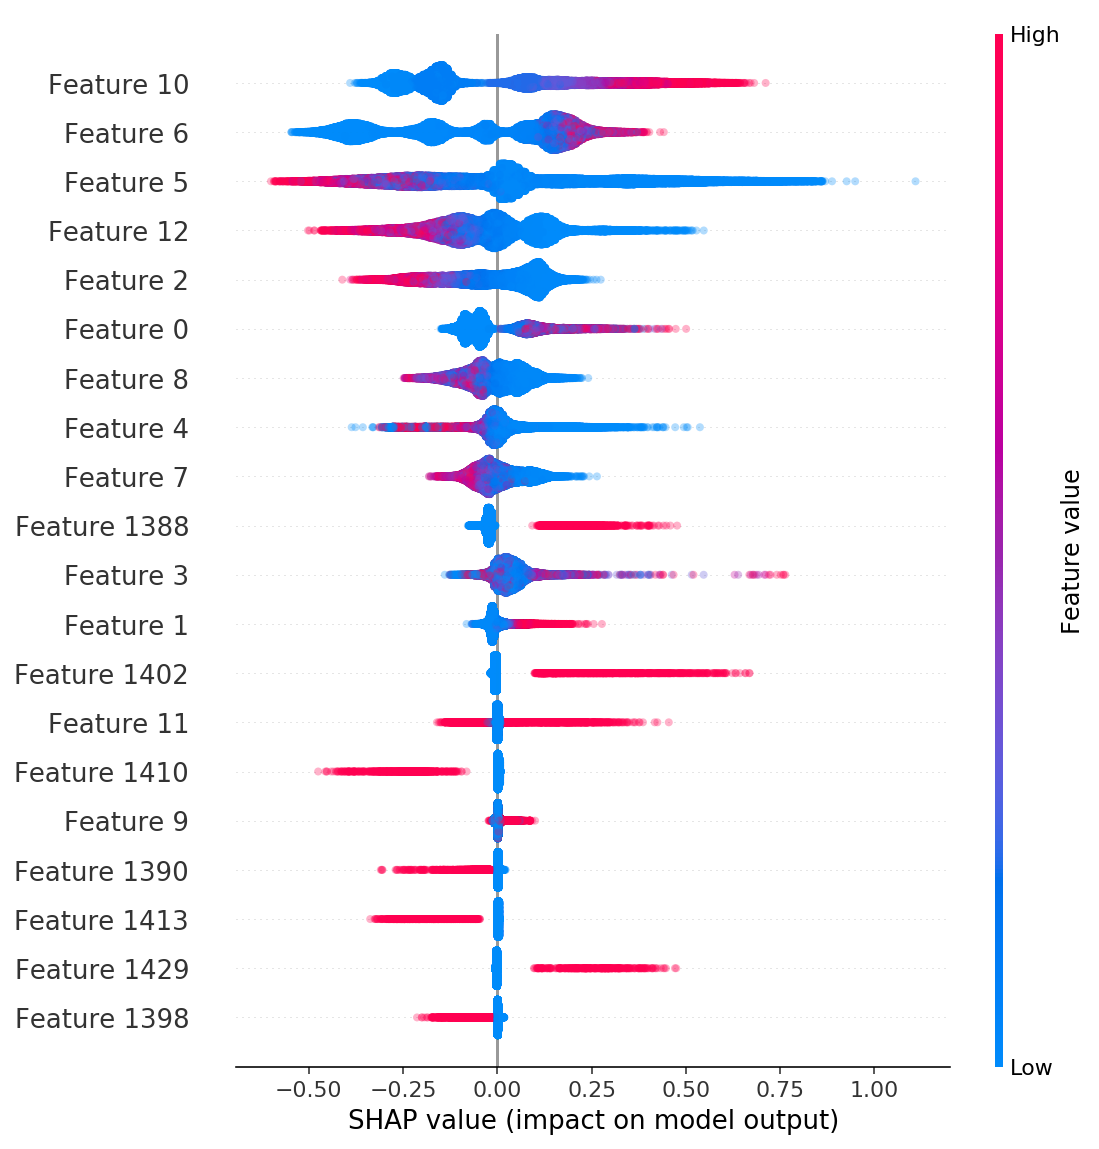

In [92]:
shap.summary_plot(shap_values, X_arr, max_display=20, alpha=0.3)

## [XGBoost features importance](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score)

In [93]:
def get_feature_score(booster, importance):
    gains_xgb = booster.get_score(importance_type=importance)
    gains = {}
    for f, g in gains_xgb.items():
        gains[f] = g
    sorted_gains = sorted(list(gains.items()), key=lambda x: -x[1])
    return sorted_gains


features_scores = get_feature_score(bst, 'gain')[:20]

In [94]:
f_names, f_scores = zip(*features_scores)
features_scores_pdf = pd.DataFrame({'feature': f_names, 'gain': f_scores})

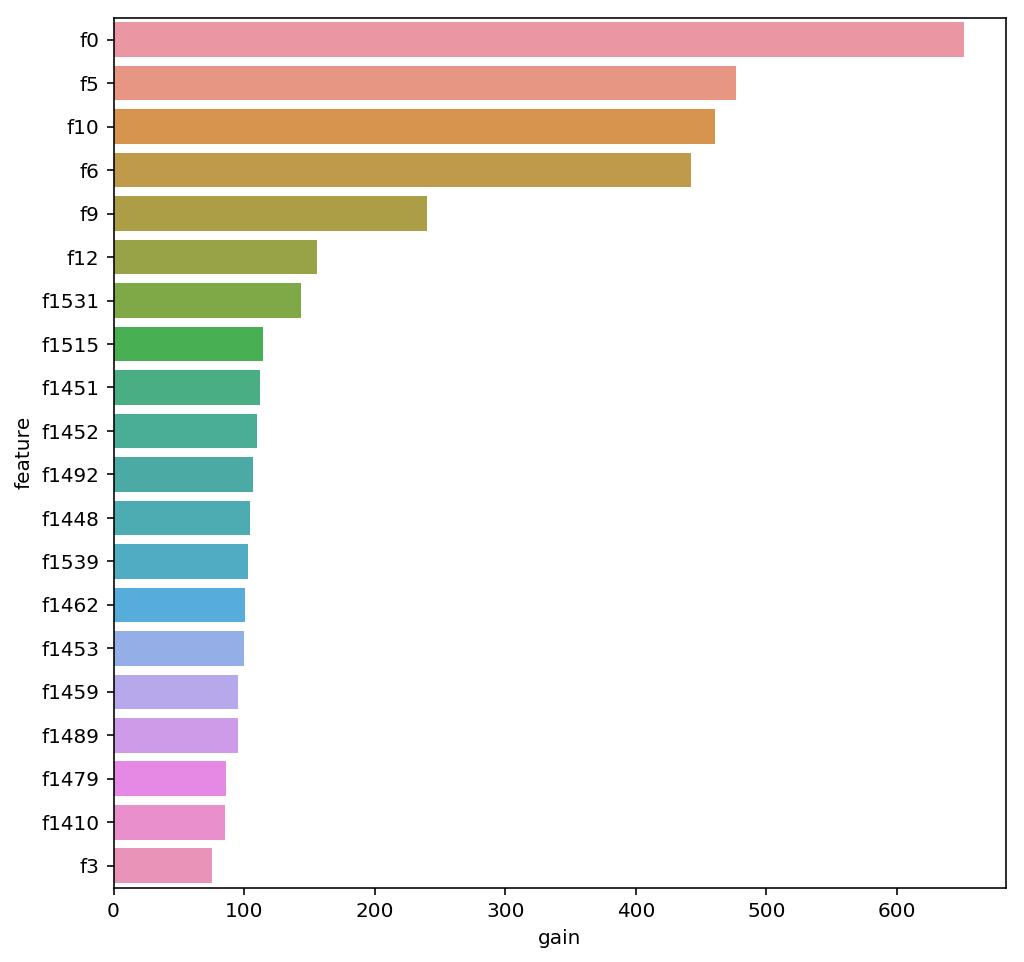

In [95]:
_, ax = plt.subplots(figsize=(8,8))
ax = sns.barplot(x='gain', y='feature', data=features_scores_pdf)
plt.show()

# [Practical Lessons From Facebook](https://quinonero.net/Publications/predicting-clicks-facebook.pdf)

* Реализуйте модель из статьи (LogReg поверх XGBoost)

* Попробуйте реализовать Negatives Subsampling + Re-calibration описанный в статье (доп. баллы)

### LogReg over XGBoost

In [96]:
def df_to_csr(df):
    data = []
    row_ind = []
    col_ind = []
    
    sparse_vecs = df.rdd.map(lambda row: row.features).collect()
    dim = len(sparse_vecs[0])
    
    for i, vec in enumerate(sparse_vecs):
        for idx, val in enumerate(vec.values):
            data.append(val)
            row_ind.append(i)
            col_ind.append(idx)
    return csr_matrix((data, (row_ind, col_ind)), shape=(len(sparse_vecs), dim))

# Regressor for raw df
class Logistic_Regressor_over_XGBoost:
    def __init__(self):
        self.xgb_estimator = XGBoostEstimator(
            featuresCol="features", 
            labelCol="label", 
            predictionCol="prediction",
            colsample_bytree=0.9,
            eta=0.15,
            gamma=0.9,
            max_depth=8,
            min_child_weight=50.0,
            subsample=0.9,
            objective='binary:logistic',
            eval_metric='logloss', 
            silent=0,
            num_round=20,
            nthread=1,
            nworkers=1
        )
        self.num_columns = num_columns = ['_c{}'.format(i) for i in range(1, 14)]
        self.xgb_estimator_path = os.path.join(DATA_PATH, 'xgb_mean_target.model')
        self.linear_model = LogisticRegression(featuresCol = 'leaf_features', labelCol = 'label', maxIter=10)
        self.pipeline_model = None
        self.max_leaf = None
    
    def fit(self, train_df):
        cat_enc_columns = [cat_col + '_enc' for cat_col in cat_columns]
        mean_target_encoders = [MeanTargetEncoder(cat_col, '_c0', cat_enc_col) 
                        for cat_col, cat_enc_col in zip(cat_columns, cat_enc_columns)]

        assembler = VectorAssembler(inputCols=num_columns + cat_enc_columns, outputCol="features").setHandleInvalid("keep")
        
        pipeline = Pipeline(stages=mean_target_encoders + [assembler])
        self.pipeline_model = pipeline.fit(train_df)
        set_train(self.pipeline_model, True)
        
        train_df = self.__prepare_df(train_df) \
            .select(F.col('_c0').alias('label'), 'features', 'id') \
            .cache()
        
        self.xgb_estimator = self.xgb_estimator.fit(train_df)
        self.__save_xgb_estimator(self.xgb_estimator)
        
        train_df_with_leafs = self.__add_leaf_features(train_df)
        self.linear_model = self.linear_model.fit(train_df_with_leafs)
    
    def transform(self, df):
        return self.predict(df)
        
    def predict(self, df):
        set_train(self.pipeline_model, False)
        
        df = self.__prepare_df(df) \
            .cache()
        
        df_with_leafs = self.__add_leaf_features(df)
        df_with_leafs.persist()
        
        return self.linear_model.transform(df_with_leafs)
        
    def __save_xgb_estimator(self, estimator):
        path = self.xgb_estimator_path
        if os.path.exists(path):
            os.remove(path)
        estimator._call_java("booster").saveModel(path)
        
    def __add_leaf_features(self, df):
        booster = xgb.Booster()
        booster.load_model(self.xgb_estimator_path)
        
        X = df_to_csr(df)
        
        dmatrix = xgb.DMatrix(X)
        leaf_sets = booster.predict(dmatrix, pred_leaf=True)
        
        if self.max_leaf is None:
            self.max_leaf = np.max(leaf_sets)
            
        def to_sparse_vector(leafs):
            leafs = np.unique(np.sort(leafs))
            return Vectors.sparse(self.max_leaf + 1, leafs, np.ones_like(leafs, dtype=np.double))
        
        num_partitions = 15
        sparse_vectors = sc.parallelize([to_sparse_vector(leafs) for leafs in leaf_sets], num_partitions)
        df_rdd         = sc.parallelize(df.rdd.collect(), num_partitions)
        
        def add_leaf_field(p):
            row, leafs = p
            row_dict = row.asDict()
            row_dict['leaf_features'] = leafs
            return Row(**row_dict)
        rdd_extended = df_rdd.zip(sparse_vectors).map(add_leaf_field)
        return spark.createDataFrame(rdd_extended)
        
    def __prepare_df(self, df):
        assert self.pipeline_model is not None
        
        df = df.fillna(0, subset=self.num_columns) 
        return self.pipeline_model.transform(df)

### XGBoost + Mean Target

In [97]:
# Regressor for raw df
class XGB_Regressor_MeanTarget:
    def __init__(self):
        self.estimator = XGBoostEstimator(
            featuresCol="features", 
            labelCol="label", 
            predictionCol="prediction",
            colsample_bytree=0.9,
            eta=0.15,
            gamma=0.9,
            max_depth=8,
            min_child_weight=50.0,
            subsample=0.9,
            objective='binary:logistic',
            eval_metric='logloss', 
            silent=0,
            num_round=20,
            nthread=1,
            nworkers=1
        )
        self.num_columns = ['_c{}'.format(i) for i in range(1, 14)]
        self.pipeline_model = None
    
    def fit(self, train_df):
        cat_columns = ['_c14', '_c15']
        cat_enc_columns = [cat_col + '_enc' for cat_col in cat_columns]
        mean_target_encoders = [MeanTargetEncoder(cat_col, '_c0', cat_enc_col) 
                        for cat_col, cat_enc_col in zip(cat_columns, cat_enc_columns)]
        print("mean target encoding ...")
        assembler = VectorAssembler(inputCols=num_columns + cat_enc_columns, outputCol="features").setHandleInvalid("keep")
        
        pipeline = Pipeline(stages=mean_target_encoders + [assembler])
        self.pipeline_model = pipeline.fit(train_df)
        set_train(self.pipeline_model, True)
        
        train_df = self.__prepare_df(train_df) \
            .select(F.col('_c0').alias('label'), 'features', 'id') \
            .cache()
        
        print("fitting xgboost ...")
        self.estimator = self.estimator.fit(train_df)
    
    def transform(self, df):
        return self.predict(df)
        
    def predict(self, df):
        set_train(self.pipeline_model, False)
        df = self.__prepare_df(df)
        predictions = self.estimator.transform(df)
        
        return predictions
        
    def __prepare_df(self, df):
        assert self.pipeline_model is not None
        
        df = df.fillna(0, subset=self.num_columns) 
        return self.pipeline_model.transform(df)

### LogReg baseline

In [98]:
# Regressor for raw df
class LogisticRegressor:
    def __init__(self):
        self.pipeline_model = PipelineModel.load(PIPELINE_MODEL_PATH)
        self.linear_model = LogisticRegression(featuresCol = 'features', labelCol = '_c0', maxIter=10)
        self.num_columns = num_columns = ['_c{}'.format(i) for i in range(1, 14)]
    
    def fit(self, train_df):
        train_df = self.__prepare_df(train_df).select('_c0', 'features', 'id')
        self.linear_model = self.linear_model.fit(train_df)
        
    def transform(self, df):
        return self.predict(df)
        
    def predict(self, df):
        df = self.__prepare_df(df)
        predictions = self.linear_model.transform(df)
        get_second_element = F.udf(lambda v:float(v[1]),FloatType())
        
        return predictions
        
    def __prepare_df(self, df):
        df = df.fillna(0, subset=self.num_columns) 
        return self.pipeline_model.transform(df)

## Prepare Data

In [99]:
df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TRAIN_PATH)

df = df.sample(0.12)

In [101]:
train, val, test = split_by_col(df, 'id', [0.8, 0.1, 0.1])

## Evaluation

In [102]:
def calibration(model, df):
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    pass

Сравните новую модель со всеми предыдущими с помощью `get_ate`. При сравнении использовать еще и метрику calibration

In [103]:
all_metrics = {}

In [104]:
test = test.withColumnRenamed('_c0', 'label')

In [105]:
regressor = LogisticRegressor()
regressor.fit(train)
all_metrics['LogReg'] = {'ROC AUC' : rocauc(regressor, test, probabilities_col='probability')}
all_metrics['LogReg']

{'ROC AUC': 0.698587950041242}

In [106]:
regressor = XGB_Regressor_MeanTarget()
regressor.fit(train)
all_metrics['XGBoost+MeanTarget'] = {'ROC AUC' : rocauc(regressor, test, probabilities_col='probabilities')}
all_metrics['XGBoost+MeanTarget']

mean target encoding ...
fitting xgboost ...


{'ROC AUC': 0.7326289689188605}

In [107]:
regressor = Logistic_Regressor_over_XGBoost()
regressor.fit(train)

[02:32:33] WARNING: /workspace/src/learner.cc:556: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility


In [108]:
all_metrics['LogReg over XGBoost'] = {'ROC AUC': rocauc(regressor, test, probabilities_col='probability')}

[02:37:04] WARNING: /workspace/src/learner.cc:556: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility


In [109]:
all_metrics

{'LogReg': {'ROC AUC': 0.698587950041242},
 'LogReg over XGBoost': {'ROC AUC': 0.696867869976906},
 'XGBoost+MeanTarget': {'ROC AUC': 0.7326289689188605}}

In [110]:
get_ate(all_metrics, 'LogReg')

,LogReg over XGBoost,LogReg,XGBoost+MeanTarget
ROC AUC,-0.002462,0.0,0.048728


### Make a Submission

Если в результате работы получилась модель, которая лучше чем ЛогРег из предыдущей практики, то точно нужно сделать submission.

In [111]:
train_df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TRAIN_PATH)

TEST_PATH  = os.path.join(DATA_PATH, 'test.csv')

test_df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TEST_PATH)

In [112]:
%%time

regressor = XGB_Regressor_MeanTarget()
regressor.fit(train_df)

mean target encoding ...
fitting xgboost ...
CPU times: user 234 ms, sys: 38.2 ms, total: 272 ms
Wall time: 8min 28s


In [113]:
test_predictions = regressor.predict(test_df)
test_predictions.first()

Row(_c15='0aadb108', _c14='fbc55dae', _c1=0, _c2=0, _c3=1, _c4=1, _c5=2723, _c6=128, _c7=14, _c8=11, _c9=338, _c10=0, _c11=7, _c12=0, _c13=1, _c16='c798ded6', _c17='91e6318a', _c18='25c83c98', _c19='fe6b92e5', _c20='869243b9', _c21='37e4aa92', _c22='a73ee510', _c23='3b08e48b', _c24='c6afb14c', _c25='1b2022a0', _c26='e0230d57', _c27='07d13a8f', _c28='815790d1', _c29='b74e1eb0', _c30='e5ba7672', _c31='7ce63c71', _c32=None, _c33=None, _c34='af5dc647', _c35=None, _c36='3a171ecb', _c37='1793a828', _c38=None, _c39=None, id=592705839438, _c14_enc=0.2488559341669087, _c15_enc=0.22520184077865585, features=DenseVector([0.0, 0.0, 1.0, 1.0, 2723.0, 128.0, 14.0, 11.0, 338.0, 0.0, 7.0, 0.0, 1.0, 0.2489, 0.2252]), probabilities=DenseVector([0.6905, 0.3095]), prediction=0.0)

In [114]:
get_second_element = F.udf(lambda v:float(v[1]),FloatType())

test_predictions \
    .withColumn('proba', get_second_element(F.col('probabilities'))) \
    .select('id', 'proba') \
    .first()

Row(id=592705839438, proba=0.3095093369483948)

In [115]:
submission_path = os.path.join(DATA_PATH, 'submition.csv')

In [116]:
test_predictions \
    .withColumn('proba', get_second_element(F.col('probabilities'))) \
    .select('id', 'proba') \
    .toPandas() \
    .to_csv(submission_path, index=False)